### 1) İş Problemi (Business Problem)

Geri dönüştürülebilir atıkların sınıflandırılması.

### 2) Veriyi Anlamak (Data Understanding)

Kullanacağımız veri seti TrashNet isimli veri setidir.
Veri seti Cam,Kağıt,Karton,Plastik,Metal ve Çöp olmak üzere altı farklı sınıftan oluşmaktadır.

Toplamda 2527 adet görüntü bulunmaktadır.

Görüntülerin Dağılımı:

* 501 Cam (Glass)

* 594 Kağıt (Paper)

* 403 Karton (Cardboard)

* 482 Plastik (Plastic)

* 410 Metal

* 137 Çöp (Trash)

Görüntüler 512 x 384 piksel boyutlarında olup, 3(RGB) kanallıdır.

### 2.1) Gerekli Kütüphaneler (Required Libraries)

In [1]:
# veri okuma ve işleme
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random,os,glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# warning
import warnings
warnings.filterwarnings("ignore")

# model değerlendirme için
from sklearn.metrics import confusion_matrix,classification_report

# modelleme için
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,SpatialDropout2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img

### 2.2) Veri Setinin Okunması (Reading the dataset)

In [2]:
dir_path = "Garbage Classification/Garbage Classification"
classes = os.listdir(dir_path)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:
#Target size ve Label(etiket) değerlerinin belirlenmesi
target_size = (224,224)
waste_labels={"cardboard":0,"glass":1,"metal":2,"paper":3,"plastic":4,"trash":5}

In [4]:
def load_datasets(path):
    """
    Bu fonksiyon görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.
    
    Parametreler:
    path:Görsellerin bulunduğu dizini ifade eder.
    
    Return:
    x:Görüntülere ait matris bilgilerini tutar.
    labels:Görüntünün ait olduğu sınıf bilgisini tutan liste.
    """
    x = []
    labels = []
    # Gönderdiğimiz path'deki görüntüleri listeleyip sıralar.
    image_paths = sorted(list(paths.list_images(path)))
    for image_path in image_paths:
        # Belirtilen pathdeki görüntüler openCV kütüphanesi ile okunur.
        img = cv2.imread(image_path)
        
        # Okunan görüntüler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirilir. target_size=(224,224)
        
        img = cv2.resize(img,target_size)
        
        #Ölçeklendirilen görüntüler x listesine eklenir.
        x.append(img)
        
        #Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı label'ı temsil etmektedir.
        label = image_path.split(os.path.sep)[-2]
        
        # Yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilen key değerine
        # karşılık value değeri alınarak label oluşturulur.
        labels.append(waste_labels[label])
        
    # Veri seti random bir şekilde karıştırılır.
    x, labels = shuffle(x, labels, random_state = 42)
    
    # Boyut ve sınıf bilgisi raporlanmaktadır.
    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))}, Gözlem sayısı: {len(labels)}")
     
    return x, labels

In [5]:
x, labels = load_datasets(dir_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6, Gözlem sayısı: 2527


In [6]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
print(input_shape)

(224, 224, 3)


### 2.3) Veri Setinden Örnekler Gösterilmesi (Displaying Samples from the Data Set)

In [7]:
def visualize_img(image_batch,label_batch):
    """
    Bu fonksiyon veri seti içerisinden görüntü görselleştirir.
    
    Parametreler:
    image_batch: Görüntülere ait matris bilgilerini tutar.
    label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.
    """
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels,num_classes = 6)[n]==1][0].title())
        plt.axis("off")

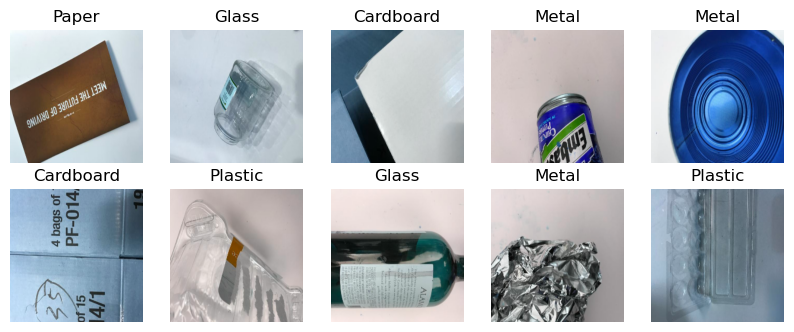

In [8]:
visualize_img(x,labels)

### 3) Veriyi Hazırlamak (Data Preparation)

In [9]:
# Train veri seti için bir generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip=True,
                          vertical_flip=True,
                          validation_split=0.1,
                          rescale=1./255,
                          shear_range=0.1,
                          zoom_range=0.1,
                          width_shift_range=0.1,
                          height_shift_range=0.1)

# Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale=1/255,validation_split=0.1)

#ImageDataGenerator fonksiyonunun görevi veri üretmektir.

In [10]:
train_generator = train.flow_from_directory(directory=dir_path,
                                           target_size=(target_size),
                                           class_mode="categorical",
                                           subset="training")
test_generator = test.flow_from_directory(directory=dir_path,
                                           target_size=(target_size),
                                           batch_size=251,
                                           class_mode="categorical",
                                           subset="validation")
# flow_from_directory: Tensorflow ortamına görüntüleri getirmek için kullanılan bir yöntemdir.
# directory: Görüntülerimizin olduğu dizindir.

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# 4) Modelleme (Modelling)
### 4.1) Sıfırdan CNN Modeli Kurma (Create a CNN model from the ground up)

***-Sequential***

***-Evrişim Katmanı(Convolution Layer,Conv2D)***

***-Havuzlama Katmanı(Pooling Layer)***

***-Aktivasyon Fonksiyonu Katmanı(Activation Layer)***

***-Flattening Katmanı***

***-Dense Katmanı***

***-Dropout Katmanı***

In [11]:
model = Sequential() # Sıralı katmanlardan oluşan evrişimli sinir ağını oluşturuyoruz.
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu")) #Evrişim katmanını 
#ekliyoruz.

#filters: Görüntü üzerinde gezdirilecek olan filtre sayısı
#kernel_size: Gezdirilecek olan filtrenin boyut bilgisi
#padding="same": Piksel ekleme.
#input_shape: Giriş görüntülerinin boyut bilgisi

model.add(MaxPooling2D(pool_size=2,strides=(2,2))) # Görünütünün özelliklerini kaybetmeden boyutunun azaltılması işlemidir.
#pool_size: Pooling işleminde görüntü üzerinde gezdirilecek olan filtrenin boyut bilgisini ifade eder.

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))

# Derin sinir ağlarında ikiden fazla katman kullanılır.

model.add(Flatten()) # Flatten,evrişim ve pooling katmanından gelen matrisleri tek boyutlu diziye çevirir.
#Veriyi sinir ağının yapısına uygun bir şekle dönüştürür.

model.add(Dense(units=64,activation="relu"))#Bir katmandan aldığı nöronların bir sonraki katmana girdi olarak bağlanmasını sağlar.
#units:nöron sayısı

model.add(Dropout(rate=0.2))# Overfitting'in önüne geçmek için kullanılır.Sinir ağının performansını artırır.
model.add(Dense(units=32,activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6,activation="softmax")) #çıkış katmanı
#units= 6= sınıf sayısı


### 4.2) Model Özeti (Model Summary)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

### 4.3) Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması (Adjusting Optimization and Evaluation Metrics)

In [13]:
model.compile(loss="categorical_crossentropy",optimizer="adam",
             metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),"acc"])
#Modeli verilen metriklere göre derler.

In [14]:
# Overfitting'i önlemek adına birkaç çalışma yapalım.
callbacks=[EarlyStopping(monitor="val_loss",patience=50,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor = "val_loss",mode="min",save_best_only=True,save_weights_only=False,
                         verbose=1)]

#monitor="val_loss": Modelin gelişimini, overfitting'i engellemek adına hangi metrik açısından takip edeceğimizi ifade eder.
#patience=50: İterasyon sayısıdır.
#verbose=1: Güncellenen sonuçlar gösterilir.
#mode="min": Modelin gelişiminin takip edileceği parametre değeridir.'min'de izlenen miktarın azalması durduğunda eğitim durur.

#ModelCheckpoint ile modelin iterasyonları devam ederken yakalanan en iyi model kaydedilir.
#filepath="mymodel.h5": Modeli ne şekilde kaydedeceğimizi gösterir.
#save_best_only=True: Sadece en iyi model kaydedilir.
#save_weights_only=False: Sadece ağırlıklar kaydedilir.


### 4.4) Modelin Eğitilmesi (Training the Model)

In [15]:
history = model.fit_generator(generator=train_generator,
                             epochs=100,
                             validation_data=test_generator,
                             callbacks=callbacks,
                             workers=4,
                             steps_per_epoch=2276//32,
                             validation_steps=251//32)
# 'epoch' sayısını arttırdığımızda, 'loss' değerinin düşmesini ve 'accuracy' değerinin artmasını bekleriz.

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.7309 - precision: 0.7273 - recall: 0.0071 - acc: 0.2313
Epoch 1: val_loss improved from inf to 1.61844, saving model to mymodel.h5
71/71 [==============================] - 54s 741ms/step - loss: 1.7309 - precision: 0.7273 - recall: 0.0071 - acc: 0.2313 - val_loss: 1.6184 - val_precision: 0.7667 - val_recall: 0.0916 - val_acc: 0.2510
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.5817 - precision: 0.6479 - recall: 0.0771 - acc: 0.3249
Epoch 2: val_loss improved from 1.61844 to 1.48437, saving model to mymodel.h5
71/71 [==============================] - 51s 720ms/step - loss: 1.5817 - precision: 0.6479 - recall: 0.0771 - acc: 0.3249 - val_loss: 1.4844 - val_precision: 0.6885 - val_recall: 0.1673 - val_acc: 0.3665
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.4394 - precision: 0.7146 - recall: 0.1529 - acc: 0.3886
Epoch 3: val_loss improved from 1.48437 to 1.45156, savin

71/71 [==============================] - 51s 710ms/step - loss: 0.9680 - precision: 0.7870 - recall: 0.4924 - acc: 0.6529 - val_loss: 0.9987 - val_precision: 0.8258 - val_recall: 0.4343 - val_acc: 0.6295
Epoch 22/100
71/71 [==============================] - ETA: 0s - loss: 0.9575 - precision: 0.7769 - recall: 0.5027 - acc: 0.6475
Epoch 22: val_loss did not improve from 0.99871
71/71 [==============================] - 50s 705ms/step - loss: 0.9575 - precision: 0.7769 - recall: 0.5027 - acc: 0.6475 - val_loss: 1.0949 - val_precision: 0.7417 - val_recall: 0.4462 - val_acc: 0.6016
Epoch 23/100
71/71 [==============================] - ETA: 0s - loss: 0.9501 - precision: 0.7709 - recall: 0.5085 - acc: 0.6613
Epoch 23: val_loss improved from 0.99871 to 0.96937, saving model to mymodel.h5
71/71 [==============================] - 51s 714ms/step - loss: 0.9501 - precision: 0.7709 - recall: 0.5085 - acc: 0.6613 - val_loss: 0.9694 - val_precision: 0.7613 - val_recall: 0.4701 - val_acc: 0.6454
Epoc

Epoch 43/100
71/71 [==============================] - ETA: 0s - loss: 0.7408 - precision: 0.8384 - recall: 0.6337 - acc: 0.7411
Epoch 43: val_loss did not improve from 0.86460
71/71 [==============================] - 50s 706ms/step - loss: 0.7408 - precision: 0.8384 - recall: 0.6337 - acc: 0.7411 - val_loss: 0.9090 - val_precision: 0.8034 - val_recall: 0.5697 - val_acc: 0.6375
Epoch 44/100
71/71 [==============================] - ETA: 0s - loss: 0.7410 - precision: 0.8188 - recall: 0.6263 - acc: 0.7293
Epoch 44: val_loss did not improve from 0.86460
71/71 [==============================] - 51s 713ms/step - loss: 0.7410 - precision: 0.8188 - recall: 0.6263 - acc: 0.7293 - val_loss: 0.9265 - val_precision: 0.8218 - val_recall: 0.5697 - val_acc: 0.6853
Epoch 45/100
71/71 [==============================] - ETA: 0s - loss: 0.7468 - precision: 0.8310 - recall: 0.6221 - acc: 0.7322
Epoch 45: val_loss did not improve from 0.86460
71/71 [==============================] - 50s 707ms/step - loss: 

71/71 [==============================] - ETA: 0s - loss: 0.6149 - precision: 0.8426 - recall: 0.7086 - acc: 0.7696
Epoch 64: val_loss did not improve from 0.74847
71/71 [==============================] - 51s 708ms/step - loss: 0.6149 - precision: 0.8426 - recall: 0.7086 - acc: 0.7696 - val_loss: 0.8562 - val_precision: 0.8241 - val_recall: 0.6534 - val_acc: 0.7251
Epoch 65/100
71/71 [==============================] - ETA: 0s - loss: 0.5964 - precision: 0.8538 - recall: 0.7157 - acc: 0.7834
Epoch 65: val_loss did not improve from 0.74847
71/71 [==============================] - 51s 716ms/step - loss: 0.5964 - precision: 0.8538 - recall: 0.7157 - acc: 0.7834 - val_loss: 0.9027 - val_precision: 0.8000 - val_recall: 0.6693 - val_acc: 0.7251
Epoch 66/100
71/71 [==============================] - ETA: 0s - loss: 0.5700 - precision: 0.8532 - recall: 0.7277 - acc: 0.7950
Epoch 66: val_loss did not improve from 0.74847
71/71 [==============================] - 50s 706ms/step - loss: 0.5700 - prec

Epoch 86/100
71/71 [==============================] - ETA: 0s - loss: 0.5478 - precision: 0.8667 - recall: 0.7562 - acc: 0.8102
Epoch 86: val_loss did not improve from 0.73452
71/71 [==============================] - 52s 728ms/step - loss: 0.5478 - precision: 0.8667 - recall: 0.7562 - acc: 0.8102 - val_loss: 0.8109 - val_precision: 0.8009 - val_recall: 0.6733 - val_acc: 0.7530
Epoch 87/100
71/71 [==============================] - ETA: 0s - loss: 0.6067 - precision: 0.8566 - recall: 0.7242 - acc: 0.7910
Epoch 87: val_loss did not improve from 0.73452
71/71 [==============================] - 52s 735ms/step - loss: 0.6067 - precision: 0.8566 - recall: 0.7242 - acc: 0.7910 - val_loss: 0.8149 - val_precision: 0.8131 - val_recall: 0.6932 - val_acc: 0.7291
Epoch 88/100
71/71 [==============================] - ETA: 0s - loss: 0.5481 - precision: 0.8624 - recall: 0.7487 - acc: 0.8133
Epoch 88: val_loss did not improve from 0.73452
71/71 [==============================] - 52s 735ms/step - loss: 

### 4.5) Accuracy ve Loss Grafikleri

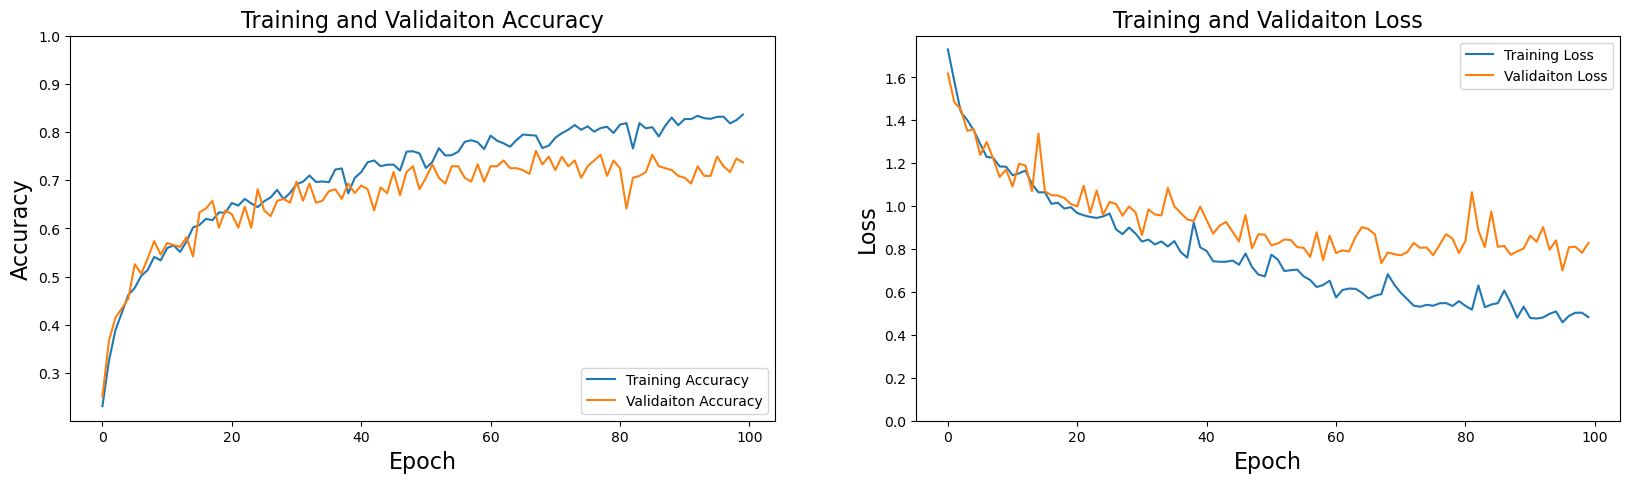

In [16]:
# Accuracy Grafiği
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history["acc"],label="Training Accuracy")
plt.plot(history.history["val_acc"],label="Validaiton Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validaiton Accuracy",fontsize=16)

# Loss Grafiği
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validaiton Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validaiton Loss",fontsize=16)
plt.show()

### 5) Değerlendirme(Evaluation)

In [17]:
loss,precision,recall,acc = model.evaluate(test_generator,batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 0.8284 - precision: 0.8047 - recall: 0.6892 - acc: 0.7371


In [18]:
#En iyi modelimizin sonuçları
print("\nTest accuracy:%.lf%%" % (100.0 * acc))
print("\nTest loss:%.lf%%" % (100.0 * loss))
print("\nTest precision:%.lf%%" % (100.0 * precision))
print("\nTest recall:%.lf%%" % (100.0 * recall))


Test accuracy:74%

Test loss:83%

Test precision:80%

Test recall:69%


In [19]:
#Classification Report
x_test,y_test = test_generator.next()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)

8/8 [==============================] - 1s 107ms/step


In [20]:
# Bağımlı değişkenin sınıflarının isimlerine erişelim
target_names = list(waste_labels.keys())

In [21]:
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.89      0.82      0.86        40
       glass       0.69      0.68      0.69        50
       metal       0.65      0.73      0.69        41
       paper       0.83      0.90      0.86        59
     plastic       0.60      0.56      0.58        48
       trash       0.80      0.62      0.70        13

    accuracy                           0.74       251
   macro avg       0.74      0.72      0.73       251
weighted avg       0.74      0.74      0.74       251



In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred)

def plot_confusion_matrix(cm,classes,normalize=False,title="Confusion Matrix",cmap=plt.cm.Blues):
    """
    Bu fonksiyon confusion matrix'i yazdırır ve çizer.
    Normalization(Normalleştirme), 'normalize=True' şeklinde ayarlanarak uygulanabilir.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(8,6))
    plt.imshow(cm,interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.xlabel("Predicted Label",fontweight = "bold")
    plt.ylabel("True label",fontweight = "bold")
    

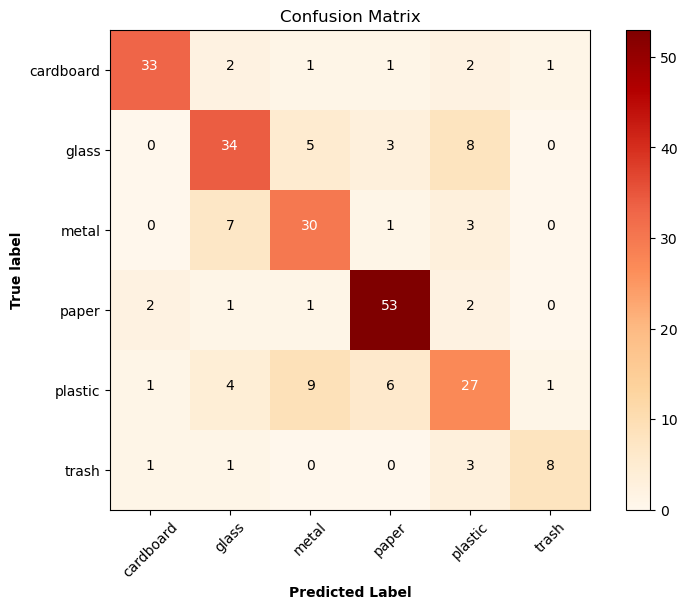

In [23]:
plot_confusion_matrix(cm,waste_labels.keys(),title="Confusion Matrix",cmap=plt.cm.OrRd)

### Modelin Kullanılması / Test Edilmesi (Using / Testing the Model)

In [24]:
waste_labels={0:"cardboard",1:"glass",2:"metal",3:"paper",4:"plastic",5:"trash"}

def model_testing(path):
    """
    Görsellerin bulunduğu dizindeki görüntüyü okuyup model aracılığı ile hangi sınıfa ait olduğuna dair tahmin işlemi
    gerçekleştirilir.
    
    Parametreler:
    path:Görsellerin bulunduğu dizini ifade eder.
    
    Return:
    img:Görüntü
    p:Tahmin Olasılıkları
    predicted_class:Tahmin sınıfı
    """
    img = image.load_img(path,target_size=(target_size))
    img = image.img_to_array(img,dtype=np.uint8)
    img = np.array(img)/255.0
    p=model.predict(img.reshape(1,224,224,3))
    predicted_class = np.argmax(p[0])
    return img,p,predicted_class

In [31]:
img1,p1,predicted_class1 = model_testing("Garbage Classification/Garbage Classification/metal/metal100.jpg")
img2,p2,predicted_class2 = model_testing("Garbage Classification/Garbage Classification/glass/glass105.jpg")
img3,p3,predicted_class3 = model_testing("Garbage Classification/Garbage Classification/cardboard/cardboard113.jpg")
img4,p4,predicted_class4 = model_testing("Garbage Classification/Garbage Classification/paper/paper107.jpg")
img5,p5,predicted_class5 = model_testing("Garbage Classification/Garbage Classification/trash/trash101.jpg")

1/1 [==============================] - 0s 21ms/step


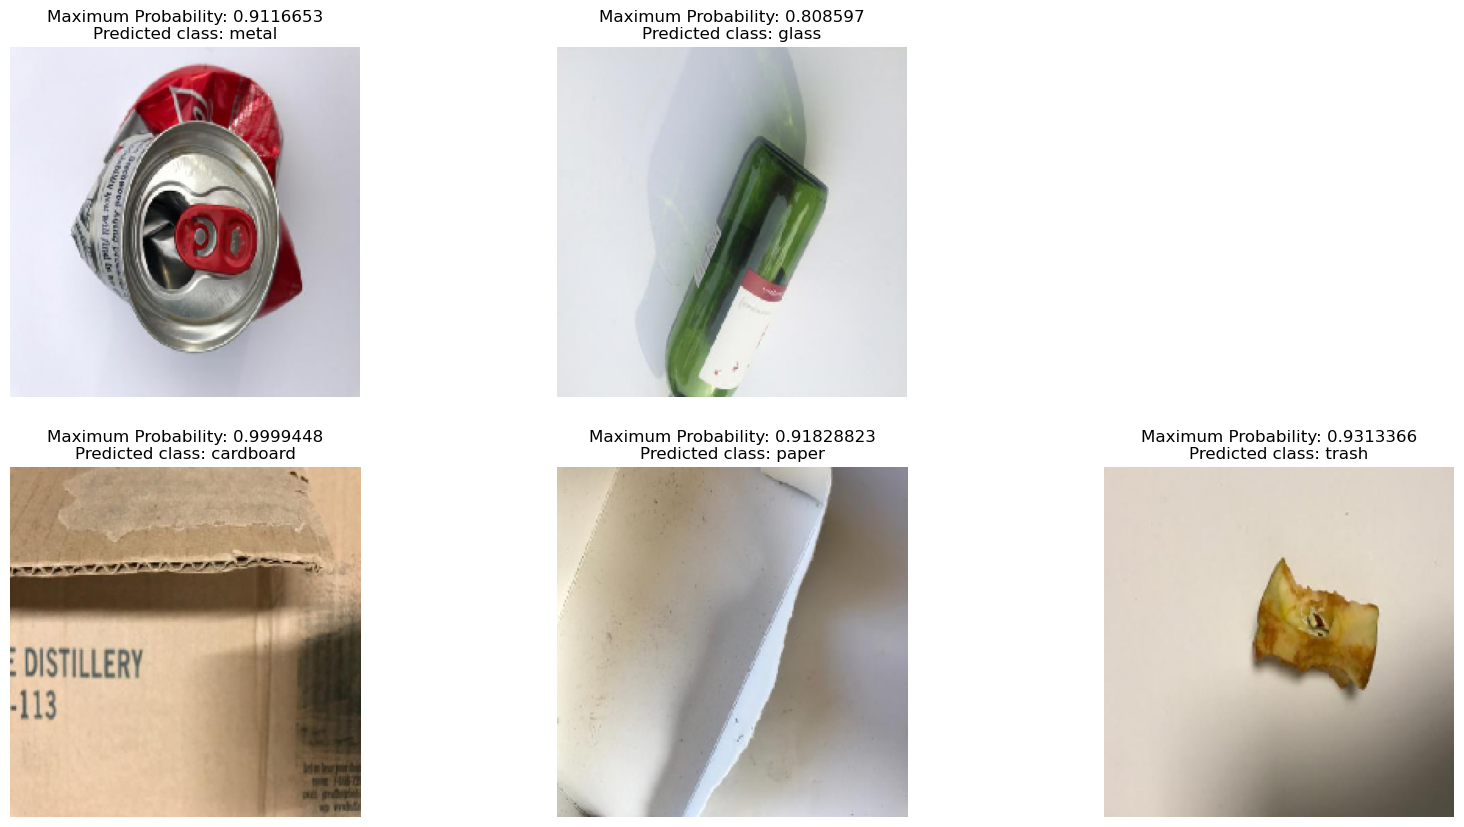

In [57]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.axis("off")
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0],axis=-1)) + "\n" + "Predicted class: "+str(waste_labels[predicted_class1]))
plt.imshow(img1);

plt.subplot(2,3,2)
plt.axis("off")
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0],axis=-1)) + "\n" + "Predicted class: "+str(waste_labels[predicted_class2]))
plt.imshow(img2);

plt.subplot(2,3,4)
plt.axis("off")
plt.imshow(img3.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0],axis=-1)) + "\n" + "Predicted class: "+str(waste_labels[predicted_class3]))
plt.imshow(img3);

plt.subplot(2,3,5)
plt.axis("off")
plt.imshow(img4.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0],axis=-1)) + "\n" + "Predicted class: "+str(waste_labels[predicted_class4]))
plt.imshow(img4);

plt.subplot(2,3,6)
plt.axis("off")
plt.imshow(img5.squeeze())
plt.title("Maximum Probability: " + str(np.max(p5[0],axis=-1)) + "\n" + "Predicted class: "+str(waste_labels[predicted_class5]))
plt.imshow(img5);